<a href="https://colab.research.google.com/github/marllusneves/PythonInference/blob/master/ReamBoot2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#Carregando o MyDrive
from google.colab import drive
drive.mount('/gdrive')

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).


In [ ]:
#Import
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as scs

In [ ]:
#Secondary functions
def drawNewSample(data,func1,func2):
  sample = np.random.choice(data,size=len(data))
  return func1(sample),func2(sample)

def ecdf(data):
#Compute ECDF for a one-dimensional array of measurements. by Wallisson Moreira de Carvalho 
# Number of data points: n
  n = len(data)
# x-data for the ECDF: x
  x = np.sort(data)
# y-data for the ECDF: y
  y = np.arange(1,n+1) / n
  return x, y

def calc_z0(meanOS,arr):
  x,y=ecdf(arr)
  p0 = np.interp(meanOS, x, y) # linear interpolation
  #Bias corrector of mean
  z0 = scs.norm.ppf(p0)
  return z0

def bcpb(z0,arr,zalp):
  #Confidence interval of Mean
  beta1 = scs.norm.cdf(2*z0-zalp)
  beta2 = scs.norm.cdf(2*z0+zalp)
  lim = np.percentile(arr,[beta1*100,beta2*100])
  return lim[0],lim[1]


In [ ]:
#Main function
def mainFun(nB,arrData,alp,OrigSample,zalp,flag):
  arr = np.empty(nB)
  for i in range(nB):
    vm,vs = drawNewSample(arrData,np.mean,np.std)
    if flag in 'Mm':
      arr[i]= vm
    elif flag in 'Ss':
      arr[i]= vs
  
  #Confidence interval (CI) - Percentile method
  cip = np.percentile(arr,[100*alp/2,100*(1-alp/2)])
  cipI = cip[0]
  cipS = cip[1]
  BootEstimates = np.mean(arr) 


  #CI - Biased-corrected percentile Bootstrap (BCPB) 
  bias = BootEstimates - OrigSample

  z0 = calc_z0(OrigSample,arr)
  cibcpbI,cibcpbS = bcpb(z0,arr,zalp)


  #CI - Accelerated bias-corrected percentile method (BCa)
  n = len(arrData)
  v1 = np.empty(n)
  v1 = arrData[:]
  v1_del = np.empty(n-1)
  Thetai = np.empty(n)
  for i in range(n):
    v1_del = np.delete([v1],i)
    Thetai[i] = np.mean(v1_del)
  ThetaDot = np.mean(Thetai)
 
  #acceleration a
  cubicSum = 0
  squareSum = 0
  for i in range(n):
    di = ThetaDot - Thetai[i]
    cubicSum += di**3
    squareSum += di**2
  a = (1/6)*cubicSum/squareSum**(3/2)

  #CI - BCa
  beta1 = scs.norm.cdf(z0-((z0 + zalp)/(1-a*(z0 + zalp))))
  beta2 = scs.norm.cdf(z0+((z0 + zalp)/(1-a*(z0 + zalp))))
  cibca = np.percentile(arr,[beta1*100,beta2*100])
  cibcaI = cibca[0]
  cibcaS = cibca[1]

  ustat = 2*OrigSample - BootEstimates
 
  return [bias,cipI,cipS,cibcpbI,cibcpbS,cibcaI,cibcaS,ustat,arr]

In [ ]:
dfData = pd.read_excel('/gdrive/My Drive/Python/Dados.xlsx',sheet_name='Planilha2') #Ler dados do mesmo arquivo do excel na Planilha2
#dfData.info()

In [ ]:
#dfData.head()

In [ ]:
#dfData.describe()

In [ ]:
#Cria o vetor com os valores de C da amostra original
strData = 'Vazões (m3/s)'
arrayData = dfData[strData]
n = len(arrayData)

In [ ]:
meanOrigSample = np.mean(arrayData)
stdOrigSample = np.std(arrayData)

In [ ]:
confidencelevel = 0.95 #confidence level
alpha = 1 - confidencelevel
zalpha2 = scs.norm.ppf(alpha/2)
zalpha2 = np.absolute(zalpha2)

Study of B values


In [ ]:
#Bt = (10,20,30) #B values as a tuple
Bt = (10,20,50,100,250,500,750,1000,2500,5000,10000) #B values as a tuple
nBt = len(Bt)

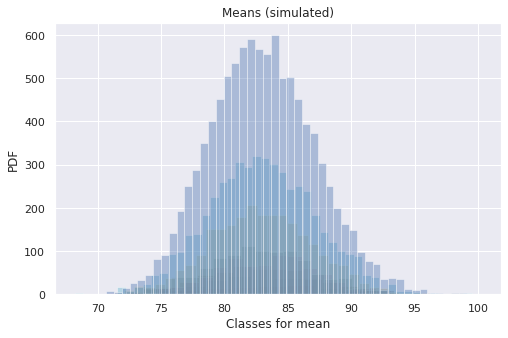

In [ ]:
#Mean
arrBiasMean = np.empty(nBt)
arrcipIMean = np.empty(nBt)
arrcipSMean = np.empty(nBt)
arrcibcpbIMean = np.empty(nBt)
arrcibcpbSMean = np.empty(nBt)
arrcibcaIMean = np.empty(nBt)
arrcibcaSMean = np.empty(nBt)
arrustatMean = np.empty(nBt)
for i,B in enumerate(Bt):
  mStudyMean = mainFun(B,arrayData,alpha,meanOrigSample,zalpha2,'M')
                  #mainFun(B,arrData,alp,OrigSample,zalp)
  #bias,cipI,cipS,cibcpbI,cibcpbS,cibcaI,cibcaS,ustat,arr
  arrBiasMean[i] = mStudyMean[0]
  arrcipIMean[i] = mStudyMean[1]
  arrcipSMean[i] = mStudyMean[2]
  arrcibcpbIMean[i] = mStudyMean[3]
  arrcibcpbSMean[i] = mStudyMean[4]
  arrcibcaIMean[i] = mStudyMean[5]
  arrcibcaSMean[i] = mStudyMean[6]
  arrustatMean[i] = mStudyMean[7]
  arrayMean=mStudyMean[8]
  #print(f'{i}  {B} {arrBiasMean[i]:.2f} {arrcipIMean[i]:.2f} {arrcipSMean[i]:.2f} {arrcibcpbIMean[i]:.2f}\
  #{arrcibcpbSMean[i]:.2f} {arrcibcaIMean[i]:.2f}  {arrcibcaSMean[i]:.2f} {arrustatMean[i]:.2f}')
  #print(arrayMean)

  if i == 0:
    fig3, axes3 = plt.subplots(ncols = 1,nrows = 1,figsize=(8,5))
    sns.set(style="darkgrid")
    axes3.set_title('Means (simulated)');
    axes3.set_xlabel('Classes for mean');
    axes3.set_ylabel('PDF')
  
  if i == nBt:
    sns.distplot(arrayMean,kde = False,rug=False,ax=axes3)
  else:
    sns.distplot(arrayMean,kde = False,rug=False,ax=axes3)
  


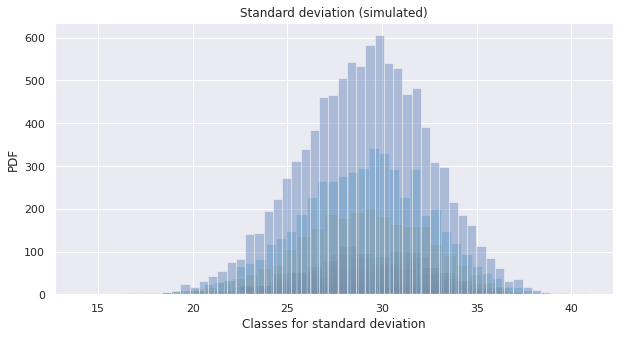

In [ ]:
#Standard deviation
arrBiasStd = np.empty(nBt)
arrcipIStd = np.empty(nBt)
arrcipSStd = np.empty(nBt)
arrcibcpbIStd = np.empty(nBt)
arrcibcpbSStd = np.empty(nBt)
arrcibcaIStd = np.empty(nBt)
arrcibcaSStd = np.empty(nBt)
arrustatStd = np.empty(nBt)
for i,B in enumerate(Bt):
  mStudyStd = mainFun(B,arrayData,alpha,stdOrigSample,zalpha2,'S')
                  #mainFun(B,arrData,alp,OrigSample,zalp)
  #bias,cipI,cipS,cibcpbI,cibcpbS,cibcaI,cibcaS,ustat,arr
  arrBiasStd[i] = mStudyStd[0]
  arrcipIStd[i] = mStudyStd[1]
  arrcipSStd[i] = mStudyStd[2]
  arrcibcpbIStd[i] = mStudyStd[3]
  arrcibcpbSStd[i] = mStudyStd[4]
  arrcibcaIStd[i] = mStudyStd[5]
  arrcibcaSStd[i] = mStudyStd[6]
  arrustatStd[i] = mStudyStd[7]
  arrayStd=mStudyStd[8]
  #print(f'{i}  {B} {arrBiasStd[i]:.2f} {arrcipIStd[i]:.2f} {arrcipSStd[i]:.2f} {arrcibcpbIStd[i]:.2f}\
  #{arrcibcpbSStd[i]:.2f} {arrcibcaIStd[i]:.2f}  {arrcibcaSStd[i]:.2f} {arrustatStd[i]:.2f}')
  #print(arrayStd)
  if i == 0:
    fig4, axes4 = plt.subplots(ncols = 1,nrows = 1,figsize=(10,5))
    sns.set(style="darkgrid")
    axes4.set_title('Standard deviation (simulated)');
    axes4.set_xlabel('Classes for standard deviation');
    axes4.set_ylabel('PDF')
  if i == nBt:
    sns.distplot(arrayStd,kde = False,rug=False,ax=axes4,color = 'black')
  else:
    sns.distplot(arrayStd,kde = False,rug=False,ax=axes4)

Plotting

In [ ]:
sns.set(style="darkgrid")

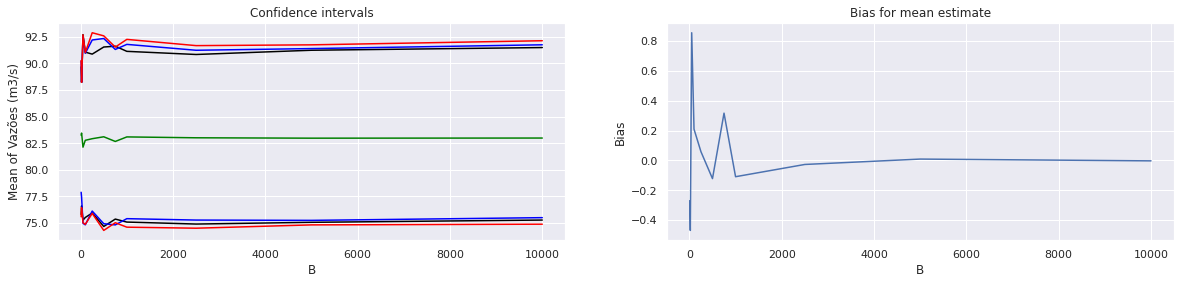

In [ ]:
#Mean
fig, axes = plt.subplots(ncols = 2,nrows = 1,figsize=(20,4))
axes[0].set_title('Confidence intervals');
axes[0].set_xlabel('B');
axes[0].set_ylabel('Mean of ' + strData)
sns.lineplot(Bt,arrcipIMean,ax=axes[0],color='black')
sns.lineplot(Bt,arrcibcpbIMean,ax=axes[0],color='blue')
sns.lineplot(Bt,arrcibcaIMean,ax=axes[0],color='red')
sns.lineplot(Bt,arrcipSMean,ax=axes[0],color='black')
sns.lineplot(Bt,arrcibcpbSMean,ax=axes[0],color='blue')
sns.lineplot(Bt,arrcibcaSMean,ax=axes[0],color='red');
sns.lineplot(Bt,arrustatMean,ax=axes[0],color='green');

sns.lineplot(Bt,arrBiasMean,ax=axes[1]);
axes[1].set_title('Bias for mean estimate');
axes[1].set_xlabel('B');
axes[1].set_ylabel('Bias');

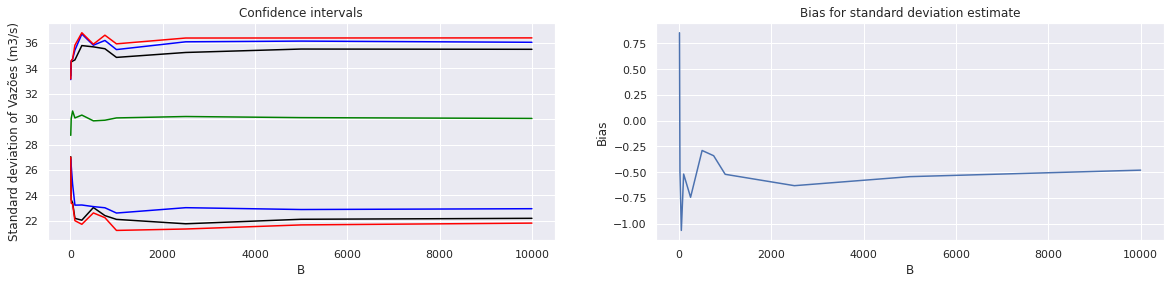

In [ ]:
#Standard deviation
fig, axes = plt.subplots(ncols = 2,nrows = 1,figsize=(20,4))
axes[0].set_title('Confidence intervals');
axes[0].set_xlabel('B');
axes[0].set_ylabel('Standard deviation of ' + strData)
sns.lineplot(Bt,arrcipIStd,ax=axes[0],color='black')
sns.lineplot(Bt,arrcibcpbIStd,ax=axes[0],color='blue')
sns.lineplot(Bt,arrcibcaIStd,ax=axes[0],color='red')
sns.lineplot(Bt,arrcipSStd,ax=axes[0],color='black')
sns.lineplot(Bt,arrcibcpbSStd,ax=axes[0],color='blue')
sns.lineplot(Bt,arrcibcaSStd,ax=axes[0],color='red');
sns.lineplot(Bt,arrustatStd,ax=axes[0],color='green');

sns.lineplot(Bt,arrBiasStd,ax=axes[1]);
axes[1].set_title('Bias for standard deviation estimate');
axes[1].set_xlabel('B');
axes[1].set_ylabel('Bias');



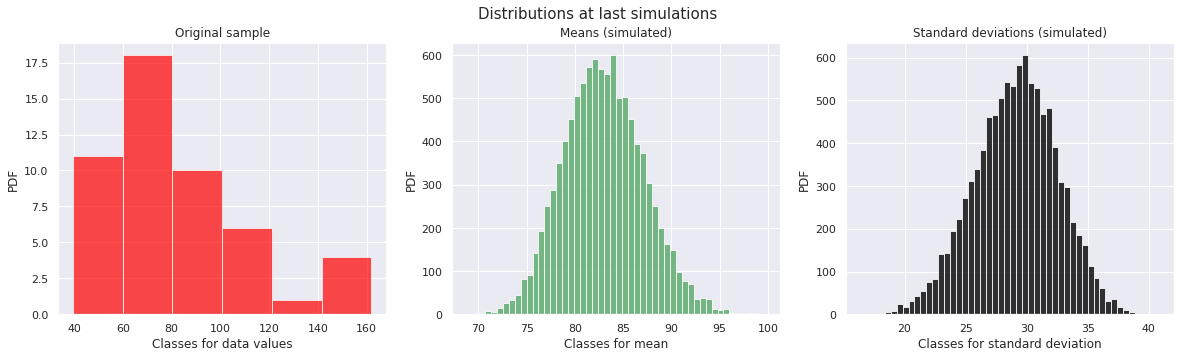

In [ ]:
#Plotting Histograms for mean and standard deviation
fig5, axes5 = plt.subplots(ncols = 3,nrows = 1,figsize=(20,5))
fig5.suptitle('Distributions at last simulations',size=15)
sns.set(style="darkgrid")

#Original sample
sns.distplot(arrayData,bins = 6,kde = False,rug=False,hist_kws={"histtype": "bar", "linewidth": 1,
                            "alpha": 0.7, "color": "red"},ax=axes5[0])
axes5[0].set_title('Original sample');
axes5[0].set_xlabel('Classes for data values');
axes5[0].set_ylabel('PDF');

#Means
sns.distplot(arrayMean,kde = False,rug=False,hist_kws={"histtype": "bar", "linewidth": 1,
                            "alpha": 0.8, "color": "g"},ax=axes5[1])
axes5[1].set_title('Means (simulated)');
axes5[1].set_xlabel('Classes for mean');
axes5[1].set_ylabel('PDF')

#Standard deviations
sns.distplot(arrayStd,kde = False,rug=False,hist_kws={"histtype": "bar", "linewidth": 1,
                            "alpha": 0.8, "color": "black"},ax=axes5[2]);
axes5[2].set_title('Standard deviations (simulated)');
axes5[2].set_xlabel('Classes for standard deviation');
axes5[2].set_ylabel('PDF');


